<a href="https://colab.research.google.com/github/etorresram/Bilateral-Trade-Flows-LATAM-China-USA-UN-Comtrade-API-/blob/main/LATAM_Trade_Flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **NETWORKS IN TRADE FLOWS**

This visualization presents a network-based analysis of bilateral export flows between Latin America and its two major global trade partners: China and the United States.     The datadatabase can be founded from the UN COMTRADE API for the year 2023, the network graphs show the direction and magnitude of export relationships across countries, emphasizing structural trade patterns and interdependencies. Each node in the network represents a country, while the edges denote the export value between Latin American exporters and their respective partners. The use of a chord diagram allows for a compact and intuitive representation of complex trade flows, highlighting the relative weight of each connection and enabling visual comparisons across countries. The database can be found in this link https://uncomtrade.org/docs/un-comtrade-api/.

In [ ]:
!pip install pandas==2.2.1
!pip install urllib3==2.2.1
!pip install comtradeapicall
!pip install holoviews hvplot bokeh
import numpy as np
import pandas as pd
import urllib3
import json
import comtradeapicall
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", module="matplotlib.font_manager")
import random
random.seed(42)

# **Loading the dataset from the UN Comtrade API**

In [10]:
# API key
subscription_key = 'My_key'

# Latin American reporter codes (M49 Standard)
reporters1 = '32,44,52,84,68,76,152,170,188,214,218,222,320,328,332,340,388,484,558,591,600,604,740,780,858,862'
reporters2 = '842,156'

# Partners: USA and China (M49 Standard)
partners1 = '842,156'
partners2 = '32,44,52,84,68,76,152,170,188,214,218,222,320,328,332,340,388,484,558,591,600,604,740,780,858,862'

# Call the API
df1 = comtradeapicall.getFinalData(
    subscription_key=subscription_key, typeCode='C', freqCode='A', clCode='HS', period='2023', reporterCode=reporters1,
    partnerCode=partners1, cmdCode='TOTAL', flowCode='X', partner2Code=None, customsCode=None, motCode=None, maxRecords=5000,
    format_output='JSON', aggregateBy=None, breakdownMode='classic', countOnly=None, includeDesc=True
)

df2 = comtradeapicall.getFinalData(
    subscription_key=subscription_key, typeCode='C', freqCode='A', clCode='HS', period='2023', reporterCode=reporters2,
    partnerCode=partners2, cmdCode='TOTAL', flowCode='X', partner2Code=None, customsCode=None, motCode=None, maxRecords=5000,
    format_output='JSON', aggregateBy=None, breakdownMode='classic', countOnly=None, includeDesc=True
)

df1 = pd.DataFrame(df1)
df2 = pd.DataFrame(df2)

# **LATAM ---> US & CHINA**

<ipython-input-11-4e88e2035a1c>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_nodes = plt.cm.get_cmap('viridis_r')


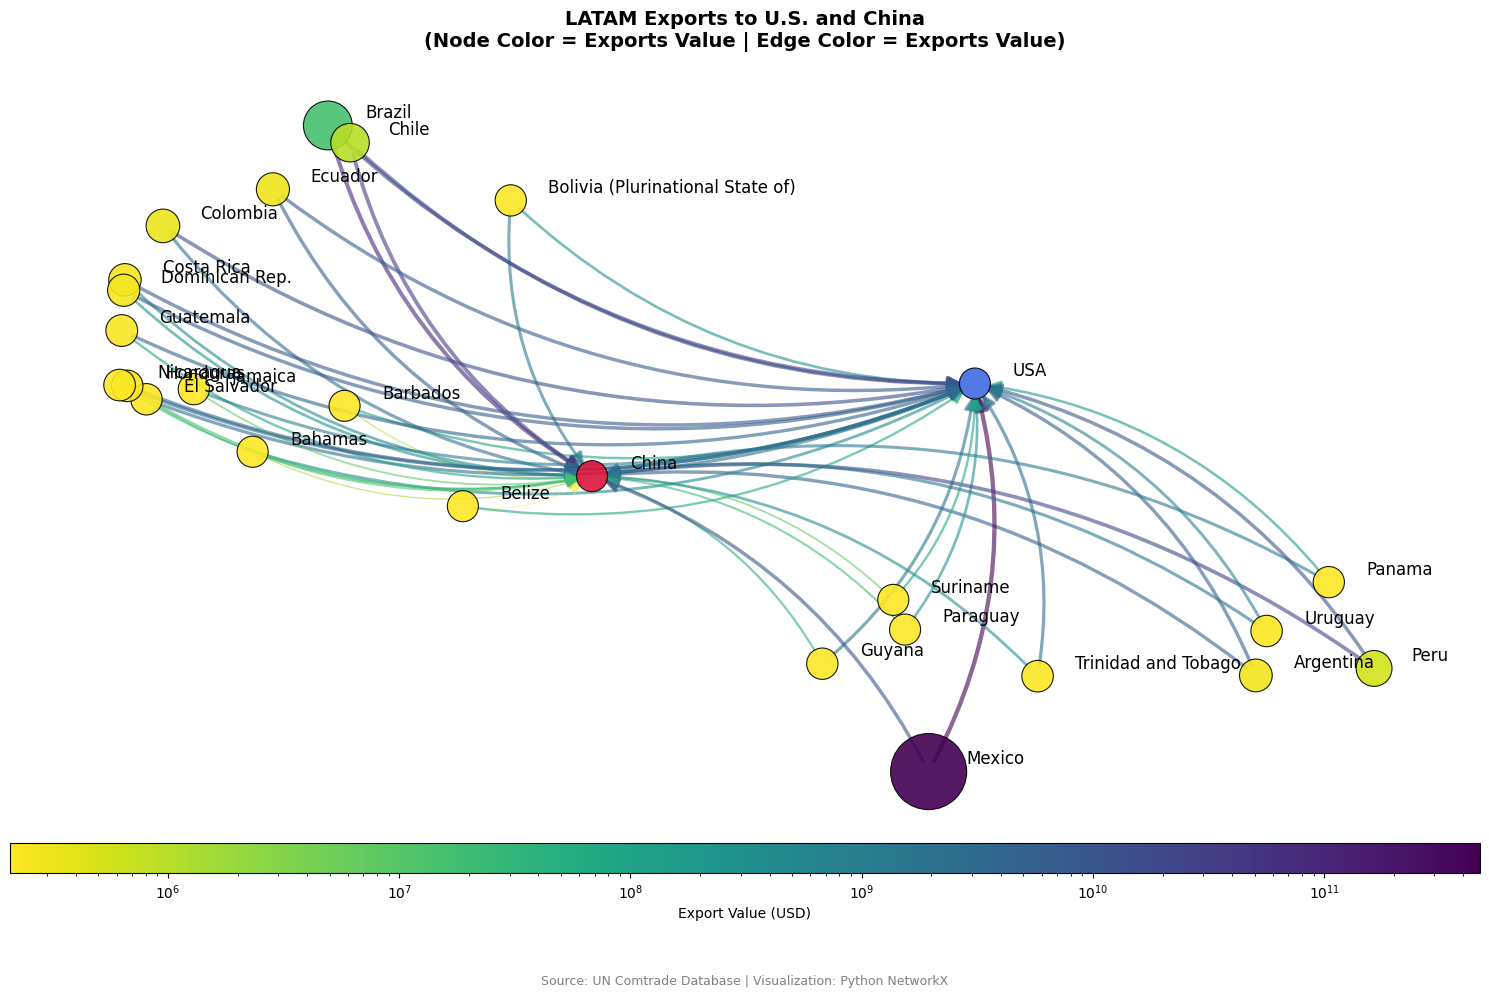

In [11]:
plt.style.use('default')
plt.rcParams['font.family'] = 'DejaVu Sans'

# --- Transformation and scaling ---
df1['log_fobvalue'] = np.log1p(df1['fobvalue'])
scaler = MinMaxScaler(feature_range=(0.3, 5))
df1['scaled_weight'] = scaler.fit_transform(df1[['log_fobvalue']])**0.7

# --- Create directed graph ---
G = nx.DiGraph()
for _, row in df1.iterrows():
    G.add_edge(
        row['reporterDesc'], row['partnerDesc'],
        weight=row['scaled_weight'],
        value=row['fobvalue']
    )

# --- Node metrics ---
total_exports = df1.groupby('reporterDesc')['fobvalue'].sum()
total_imports = df1.groupby('partnerDesc')['fobvalue'].sum()

scaler = MinMaxScaler(feature_range=(500, 3000))
export_sizes = scaler.fit_transform(total_exports.values.reshape(-1, 1)).flatten()
node_size_dict = dict(zip(total_exports.index, export_sizes))

# --- Node colors based on export volume ---
export_norm = MinMaxScaler().fit_transform(total_exports.values.reshape(-1, 1)).flatten()
export_color_dict = dict(zip(total_exports.index, export_norm))
cmap_nodes = plt.cm.get_cmap('viridis_r')
node_colors = [cmap_nodes(export_color_dict.get(n, 0)) for n in G.nodes()]

# Cambiar color de nodos específicos (China y USA)
highlight_nodes = {'China': 'crimson', 'USA': 'royalblue'}
node_colors = [
    highlight_nodes[n] if n in highlight_nodes else cmap_nodes(export_color_dict.get(n, 0))
    for n in G.nodes()
]

# --- Improved layout ---
pos = nx.kamada_kawai_layout(G)

# --- Visualization ---
fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')

# Edges colored by trade value
cmap_edges = plt.get_cmap('viridis_r')
norm_edges = mcolors.LogNorm(vmin=df1['fobvalue'].min(), vmax=df1['fobvalue'].max())

for u, v, d in G.edges(data=True):
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        edge_color=[cmap_edges(norm_edges(d['value']))],
        width=d['weight'],
        alpha=0.6,
        arrowsize=20,
        arrowstyle='-|>',
        connectionstyle='arc3,rad=0.2',
        ax=ax
    )

# Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=[node_size_dict.get(n, 500) for n in G.nodes()],
    node_color=node_colors,
    edgecolors='black',
    linewidths=0.8,
    alpha=0.9,
    ax=ax
)

# --- Labels outside the nodes ---
label_offset = 0.04
for node, (x, y) in pos.items():
    ax.text(
        x + label_offset, y + label_offset,
        node,
        fontsize=12,
        #fontweight='bold',
        color='black',
        ha='left',
        va='center',
        zorder=10
    )

# --- Horizontal colorbar ---
sm_edges = plt.cm.ScalarMappable(cmap=cmap_edges, norm=norm_edges)
sm_edges.set_array([])
cbar = fig.colorbar(sm_edges, ax=ax, orientation='horizontal', pad=0.02, aspect=50)
cbar.set_label('Export Value (USD)', fontsize=10)

# Title
ax.set_title("LATAM Exports to U.S. and China\n(Node Color = Exports Value | Edge Color = Exports Value)",
             fontsize=14, pad=20, fontweight='bold')

# Source annotation
fig.text(0.5, 0.01, 'Source: UN Comtrade Database | Visualization: Python NetworkX',
         ha='center', fontsize=9, color='gray')

ax.axis('off')
plt.tight_layout()
plt.show()


In [12]:
import holoviews as hv
import hvplot.pandas
hv.extension('bokeh')
random.seed(42)

# --- Filter relevant data ---
df_filtered = df1[df1['fobvalue'] > 1e6]

# --- Prepare unique nodes ---
nodes = pd.DataFrame({
    'name': pd.unique(df_filtered[['reporterDesc', 'partnerDesc']].values.ravel())
})
nodes['index'] = nodes.index

name_to_index = dict(zip(nodes['name'], nodes['index']))

# --- Build links (edges) ---
links = pd.DataFrame({
    'source': df_filtered['reporterDesc'].map(name_to_index),
    'target': df_filtered['partnerDesc'].map(name_to_index),
    'value': df_filtered['fobvalue']
})

# --- Assign custom colors ---
color_dict = {}

# Random palette for all countries except China and the USA
palette = hv.Cycle('Category20').values * 5  # Repeat colors if there are many countries
random.shuffle(palette)

i = 0
for name in nodes['name']:
    if name == 'China':
        color_dict[name] = 'crimson'
    elif name == 'USA':
        color_dict[name] = 'dodgerblue'
    else:
        color_dict[name] = palette[i]
        i += 1

# Map colors to nodes and links
nodes['color'] = nodes['name'].map(color_dict)
links['color'] = df_filtered['reporterDesc'].map(color_dict)

# --- Plot the chord diagram with unique colors ---
chord = hv.Chord((links, hv.Dataset(nodes, 'index')))

chord.opts(
    width=900,
    height=900,
    title="Latin American Exports to the USA and China (2023)",
    labels='name',
    node_color='color',
    edge_color='color',
    edge_line_width=1.2,
    edge_alpha=1,
    node_size=12,
    fontscale=1.3,
    tools=['hover']
)


:Chord   [source,target]   (value,color)

#**US & CHINA --->  LATAM**

<ipython-input-14-5d47d6ef9401>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_nodes = plt.cm.get_cmap('cool')


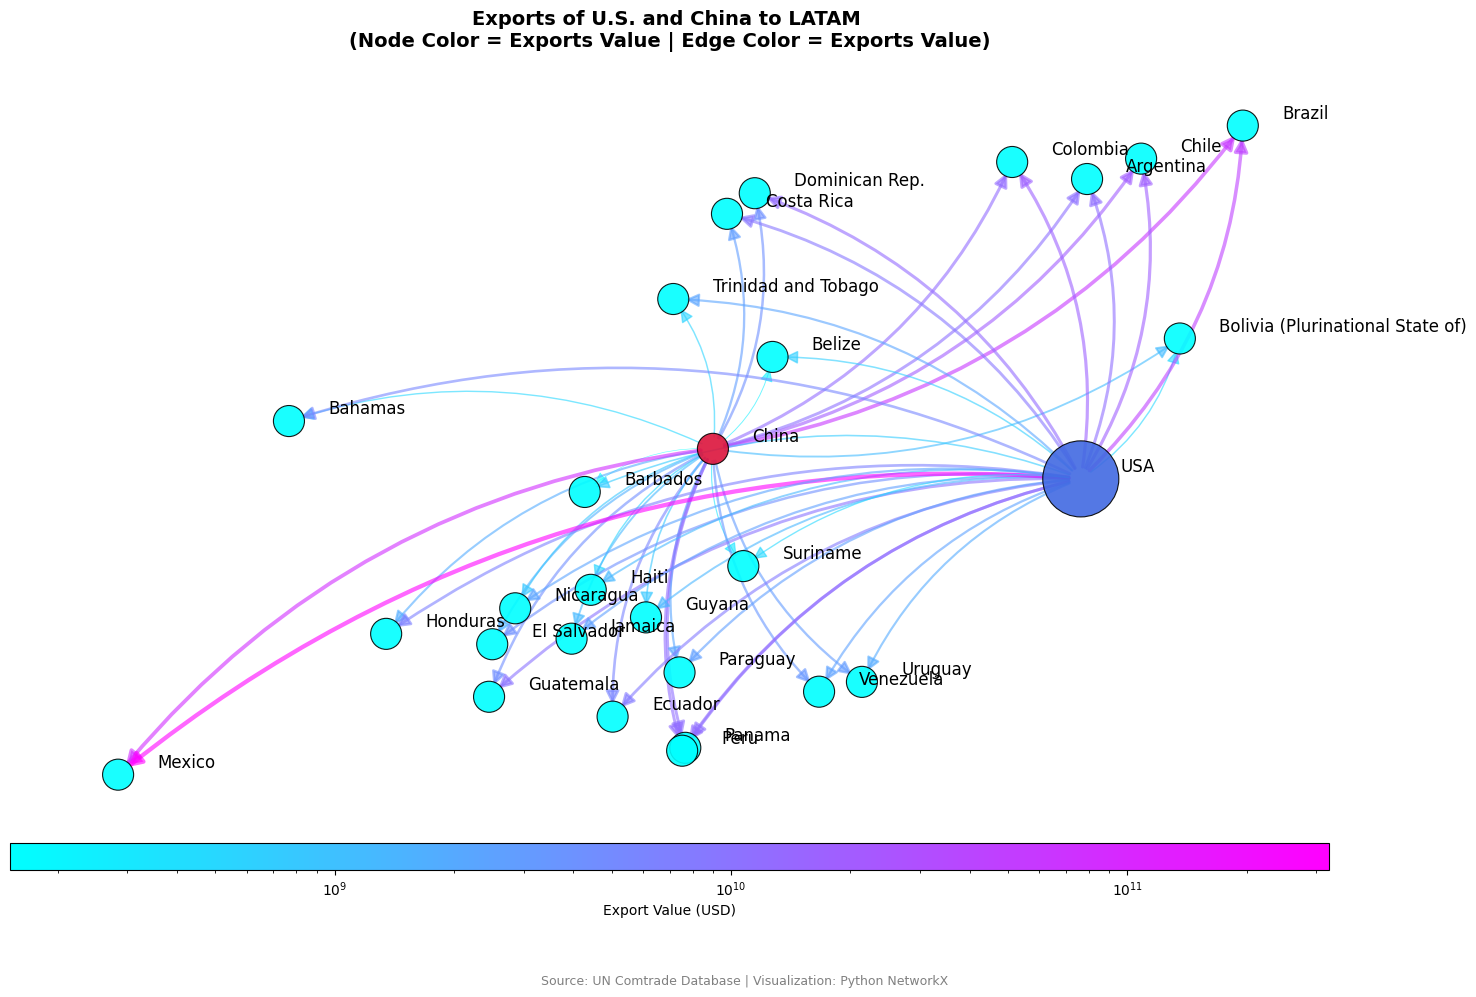

In [14]:


# Clean and professional style
plt.style.use('default')
plt.rcParams['font.family'] = 'DejaVu Sans'

# --- Transformation and scaling ---
df2['log_fobvalue'] = np.log1p(df2['fobvalue'])
scaler = MinMaxScaler(feature_range=(0.3, 5))
df2['scaled_weight'] = scaler.fit_transform(df2[['log_fobvalue']])**0.7

# --- Create directed graph ---
G = nx.DiGraph()
for _, row in df2.iterrows():
    G.add_edge(
        row['reporterDesc'], row['partnerDesc'],
        weight=row['scaled_weight'],
        value=row['fobvalue']
    )

# --- Node metrics ---
total_exports = df2.groupby('reporterDesc')['fobvalue'].sum()
total_imports = df2.groupby('partnerDesc')['fobvalue'].sum()

scaler = MinMaxScaler(feature_range=(500, 3000))
export_sizes = scaler.fit_transform(total_exports.values.reshape(-1, 1)).flatten()
node_size_dict = dict(zip(total_exports.index, export_sizes))

# --- Node colors based on export volume ---
export_norm = MinMaxScaler().fit_transform(total_exports.values.reshape(-1, 1)).flatten()
export_color_dict = dict(zip(total_exports.index, export_norm))
cmap_nodes = plt.cm.get_cmap('cool')
node_colors = [cmap_nodes(export_color_dict.get(n, 0)) for n in G.nodes()]

# Cambiar color de nodos específicos (China y USA)
highlight_nodes = {'China': 'crimson', 'USA': 'royalblue'}
node_colors = [
    highlight_nodes[n] if n in highlight_nodes else cmap_nodes(export_color_dict.get(n, 0))
    for n in G.nodes()
]

# --- Improved layout ---
pos = nx.kamada_kawai_layout(G)

# --- Visualization ---
fig, ax = plt.subplots(figsize=(15, 10), facecolor='white')

# Edges colored by trade value
cmap_edges = plt.get_cmap('cool')
norm_edges = mcolors.LogNorm(vmin=df2['fobvalue'].min(), vmax=df2['fobvalue'].max())

for u, v, d in G.edges(data=True):
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        edge_color=[cmap_edges(norm_edges(d['value']))],
        width=d['weight'],
        alpha=0.6,
        arrowsize=20,
        arrowstyle='-|>',
        connectionstyle='arc3,rad=0.2',
        ax=ax
    )

# Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=[node_size_dict.get(n, 500) for n in G.nodes()],
    node_color=node_colors,
    edgecolors='black',
    linewidths=0.8,
    alpha=0.9,
    ax=ax
)

# --- Labels outside the nodes ---
label_offset = 0.035
for node, (x, y) in pos.items():
    ax.text(
        x + label_offset, y + label_offset,
        node,
        fontsize=12,
        #fontweight='bold',
        color='black',
        ha='left',
        va='center',
        zorder=10
    )

# --- Horizontal colorbar ---
sm_edges = plt.cm.ScalarMappable(cmap=cmap_edges, norm=norm_edges)
sm_edges.set_array([])
cbar = fig.colorbar(sm_edges, ax=ax, orientation='horizontal', pad=0.02, aspect=50)
cbar.set_label('Export Value (USD)', fontsize=10)

# Title
ax.set_title("Exports of U.S. and China to LATAM \n(Node Color = Exports Value | Edge Color = Exports Value)",
             fontsize=14, pad=20, fontweight='bold')

# Source annotation
fig.text(0.5, 0.01, 'Source: UN Comtrade Database | Visualization: Python NetworkX',
         ha='center', fontsize=9, color='gray')

ax.axis('off')
plt.tight_layout()
plt.show()

In [15]:
random.seed(42)
# --- Filter relevant data ---
df_filtered = df2[df2['fobvalue'] > 1e6]

# --- Prepare unique nodes ---
nodes = pd.DataFrame({
    'name': pd.unique(df_filtered[['reporterDesc', 'partnerDesc']].values.ravel())
})
nodes['index'] = nodes.index

name_to_index = dict(zip(nodes['name'], nodes['index']))

# --- Build links (edges) ---
links = pd.DataFrame({
    'source': df_filtered['reporterDesc'].map(name_to_index),
    'target': df_filtered['partnerDesc'].map(name_to_index),
    'value': df_filtered['fobvalue']
})

# --- Assign custom colors ---
color_dict = {}

# Random palette for all countries except China and the USA
palette = hv.Cycle('Category20').values * 5  # Repeat colors if there are many countries
random.shuffle(palette)

i = 0
for name in nodes['name']:
    if name == 'China':
        color_dict[name] = 'crimson'
    elif name == 'USA':
        color_dict[name] = 'dodgerblue'
    else:
        color_dict[name] = palette[i]
        i += 1

# Map colors to nodes and links
nodes['color'] = nodes['name'].map(color_dict)
links['color'] = df_filtered['reporterDesc'].map(color_dict)

# --- Plot the chord diagram with unique colors ---
chord = hv.Chord((links, hv.Dataset(nodes, 'index')))

chord.opts(
    width=900,
    height=900,
    title="Exports of U.S. and China to LATAM (2023)",
    labels='name',
    node_color='color',
    edge_color='color',
    edge_line_width=1.2,
    edge_alpha=1,
    node_size=12,
    fontscale=1.3,
    tools=['hover']
)

:Chord   [source,target]   (value,color)